Name: Berkay Doruk

Album Number: 409437  

Lab no: 6

In [6]:
%matplotlib inline
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt


In [8]:
# === PARAMETERS ============================================================
GRID_SIZE = 32
N_PART = 32_000
DX = 1.0 / GRID_SIZE

VEL_U, VEL_V = 0.25, 0.15
N_STEP = 40
DT = 1.0 / N_STEP

ROTATIONS = 2
SWIRL_STEPS = 120
DT_SWIRL = 1.0 / SWIRL_STEPS

GAUSS_MU = np.array([0.30, 0.40])
GAUSS_SIGMA = 0.075

rng = np.random.default_rng(seed=44)


In [10]:
# === HELPERS ==============================================================

def gaussian_weights(x_pos: np.ndarray, y_pos: np.ndarray) -> np.ndarray:
    expo = -((x_pos - GAUSS_MU[0]) ** 2 + (y_pos - GAUSS_MU[1]) ** 2) / (2.0 * GAUSS_SIGMA**2)
    wts = np.exp(expo)
    return wts / wts.sum()


def make_hist(ix: np.ndarray, iy: np.ndarray, wts: np.ndarray) -> np.ndarray:
    hist = np.zeros((GRID_SIZE, GRID_SIZE))
    np.add.at(hist, (ix, iy), wts)
    return hist / hist.sum()


def advect_uniform(ix: np.ndarray, iy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    prob_x = abs(VEL_U) * DT / DX
    prob_y = abs(VEL_V) * DT / DX
    sx, sy = int(np.sign(VEL_U)), int(np.sign(VEL_V))
    for _ in range(N_STEP):
        ix += (rng.random(N_PART) < prob_x) * sx
        iy += (rng.random(N_PART) < prob_y) * sy
        ix %= GRID_SIZE
        iy %= GRID_SIZE
    return ix, iy


def advect_swirl(ix: np.ndarray, iy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    for _ in range(ROTATIONS * SWIRL_STEPS):
        xc = (ix + 0.5) * DX - 0.5
        yc = (iy + 0.5) * DX - 0.5
        uu, vv = -2.0 * np.pi * yc, 2.0 * np.pi * xc
        ix += (rng.random(N_PART) < np.abs(uu) * DT_SWIRL / DX) * np.sign(uu).astype(int)
        iy += (rng.random(N_PART) < np.abs(vv) * DT_SWIRL / DX) * np.sign(vv).astype(int)
        ix %= GRID_SIZE
        iy %= GRID_SIZE
    return ix, iy


def plot_pair(a: np.ndarray, b: np.ndarray, titles: tuple[str, str]) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
    im0 = ax[0].imshow(a.T, origin='lower', extent=(0, GRID_SIZE, 0, GRID_SIZE),
                       cmap='viridis', interpolation='bilinear')
    ax[1].imshow(b.T, origin='lower', extent=(0, GRID_SIZE, 0, GRID_SIZE),
                 cmap='viridis', interpolation='bilinear')
    ticks = np.arange(0, GRID_SIZE + 4, 4)
    for sub_ax, ttl in zip(ax, titles, strict=True):
        sub_ax.set_title(ttl)
        sub_ax.set_xlabel('x')
        sub_ax.set_ylabel('y')
        sub_ax.set_xticks(ticks)
        sub_ax.set_yticks(ticks)
        sub_ax.set_xlim(0, GRID_SIZE)
        sub_ax.set_ylim(0, GRID_SIZE)
        sub_ax.grid(True, color='white', lw=0.6, alpha=0.3)
    fig.colorbar(im0, ax=ax, location='right', shrink=0.8, label='pdf [1]')
    plt.show()



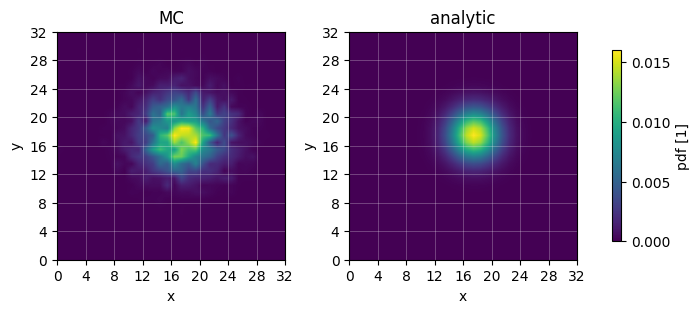

L2 error (translation): 0.0015297093133383615


In [ ]:
# === INITIAL SAMPLE =======================================================
x_r = rng.random(N_PART)
y_r = rng.random(N_PART)
weights = gaussian_weights(x_r, y_r)

ix0 = (x_r / DX).astype(int)
iy0 = (y_r / DX).astype(int)
init_hist = make_hist(ix0, iy0, weights)

# === UNIFORM TRANSLATION ==================================================
ix_t, iy_t = advect_uniform(ix0.copy(), iy0.copy())
mc_hist = make_hist(ix_t, iy_t, weights)

shift_vec = np.array([VEL_U * DT * N_STEP, VEL_V * DT * N_STEP])
gx, gy = np.meshgrid((np.arange(GRID_SIZE) + 0.5) * DX, (np.arange(GRID_SIZE) + 0.5) * DX, indexing='ij')
ana_hist = gaussian_weights(gx - shift_vec[0], gy - shift_vec[1])

plot_pair(mc_hist, ana_hist, ('MC', 'analytic'))
print('L2 error (translation):', np.sqrt(((mc_hist - ana_hist) ** 2).mean()))



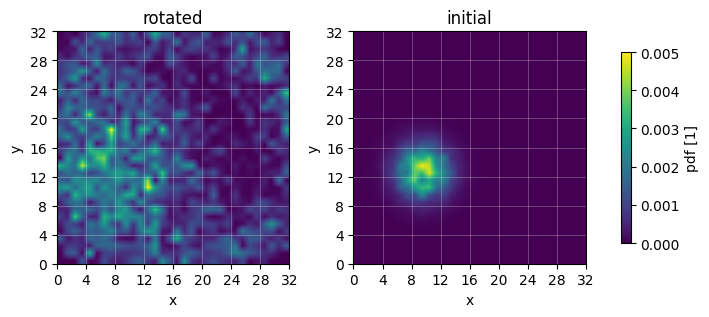

L2 error (Molenkamp): 0.0034295427181115588


In [12]:
# === MOLENKAMP ROTATION ===================================================
ix_s, iy_s = advect_swirl(ix0.copy(), iy0.copy())
swirl_hist = make_hist(ix_s, iy_s, weights)

plot_pair(swirl_hist, init_hist, ('rotated', 'initial'))
print('L2 error (Molenkamp):', np.sqrt(((swirl_hist - init_hist) ** 2).mean()))

